In [108]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from sqlalchemy import desc

In [109]:
import numpy as np
import pandas as pd

In [64]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [11]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

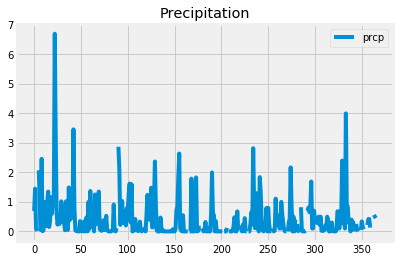

In [83]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date

last_12 = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= "2016-08-23").group_by(Measurement.date).all()
last_12_df = pd.DataFrame(last_12)
last_12_df.head()
# Use Pandas Plotting with Matplotlib to plot the data
last_12_df.plot()
plt.title("Precipitation")
plt.show()

In [84]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_stats = last_12_df.describe()
prcp_stats

,prcp
count,345.000000
mean,0.432087
std,0.704363
min,0.000000
25%,0.010000
50%,0.140000
75%,0.580000
max,6.700000


In [85]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(func.count(Station.name)).distinct()
for station in stations:
    print(f'There are {station[0]} stations')


There are 9 stations


In [86]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active = session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()

for result in most_active:
    print(result)

most_active_station = most_active[0][0]
print(f'The most active station is {most_active_station}')

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)
The most active station is USC00519281


In [87]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
lowest_temp = [func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs),]
temp_query = session.query(*lowest_temp).\
    filter(Measurement.station == most_active_station).all()
print(f'The lowest temp was {temp_query[0][0]}F.')  
print(f'The highest temp was {temp_query[0][1]}F')
print(f'The average temp was {round(temp_query[0][2],2)}F')


The lowest temp was 54.0F.
The highest temp was 85.0F
The average temp was 71.66F


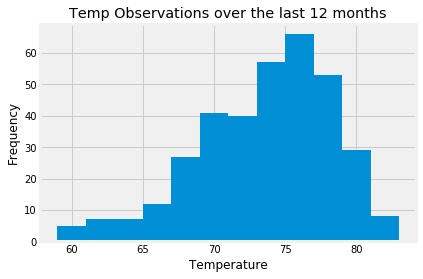

In [91]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

tobs = session.query(Measurement.tobs).filter(Measurement.date >= "2016-08-23", Measurement.station == most_active_station).all()
tobs_df = pd.DataFrame(tobs)
tobs_df.head()
plt.hist(tobs_df["tobs"], bins=12)
plt.title("Temp Observations over the last 12 months")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

In [94]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [102]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start_date = ('2017-06-10')
trip_end_date = ('2017-06-24')
print(f'The start date is {trip_end_date}')
print(f'The end date is {trip_start_date}')

prev_year = calc_temps(trip_start_date, trip_end_date)
tmin = prev_year[0][0]
tavg = round(prev_year[0][1],2)
tmax = prev_year[0][2]
print(f'The minimum temp is {tmin}')
print(f'The average temp is {tavg}')
print(f'The minimummaximum temp is {tmax}')

The start date is 2017-06-24
The end date is 2017-06-10
The minimum temp is 71.0
The average temp is 76.81
The minimummaximum temp is 83.0


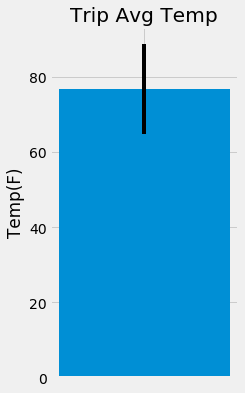

In [114]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.figure(figsize=(3,6)) 
plt.bar(x='',height=tavg, yerr=tdif)
plt.ylabel('Temp(F)')
plt.title('Trip Avg Temp')
plt.show()

In [110]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel = [func.sum(Measurement.prcp).label('precip'),
       Station.station,
      Station.name,
      Station.latitude,
      Station.longitude,
      Station.elevation]
precip = session.query(*sel).\
filter(Measurement.station==Station.station).\
filter(func.strftime("%Y-%m-%d", Measurement.date) > trip_start_date).\
filter(func.strftime("%Y-%m-%d", Measurement.date) < trip_end_date).\
group_by(Station.station).order_by(desc('precip')).all()

dfp = pd.DataFrame(precip)
dfp

,precip,station,name,latitude,longitude,elevation
0,7.35,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,2.81,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,2.07,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,1.68,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
4,0.54,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
5,0.17,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
6,0.00,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


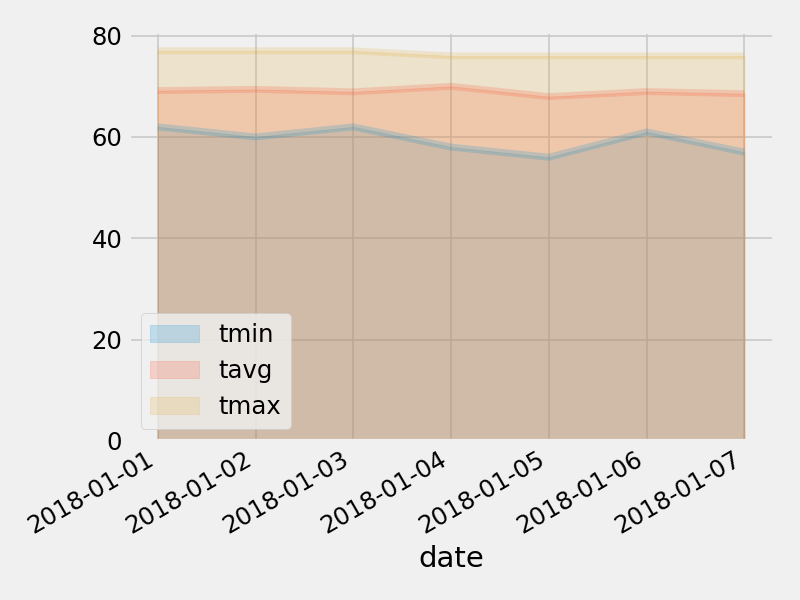

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
